### <b>IMDb kNN Classifier</b> 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, LearningCurveDisplay, PredefinedSplit
from sklearn.metrics import ConfusionMatrixDisplay
from scipy import sparse

seed = 1234
np.random.seed(seed)

In [2]:
# Load the dataset and perform train-test-validation split
dataset = load_dataset("imdb").shuffle(seed=seed)
vectorizer = TfidfVectorizer().fit(dataset["train"]["text"])

train_texts = vectorizer.transform(dataset["train"]["text"])
train_labels = np.array(dataset["train"]["label"])

test_X = vectorizer.transform(dataset["test"]["text"])
test_y = np.array(dataset["test"]["label"])

train_X, valid_X, train_y, valid_y = train_test_split(
    train_texts,
    train_labels,
    test_size=0.25,
    random_state=seed,
    stratify=train_labels
)

In [3]:
# Calculate classifier error for different k-values
def calculate_errors(k_vals) -> tuple[list, list]:
    train_error = []
    validation_error = []

    for k in k_vals:
        knn = KNeighborsClassifier(metric="cosine", n_neighbors=k, n_jobs=-1)
        knn.fit(train_X, train_y)
        train_error.append(1 - knn.score(train_X, train_y))
        validation_error.append(1 - knn.score(valid_X, valid_y))
    
    return train_error, validation_error


k_vals = [1, 5, 11, 21, 31, 41, 51, 61, 71]
train_error, valid_error = calculate_errors(k_vals)

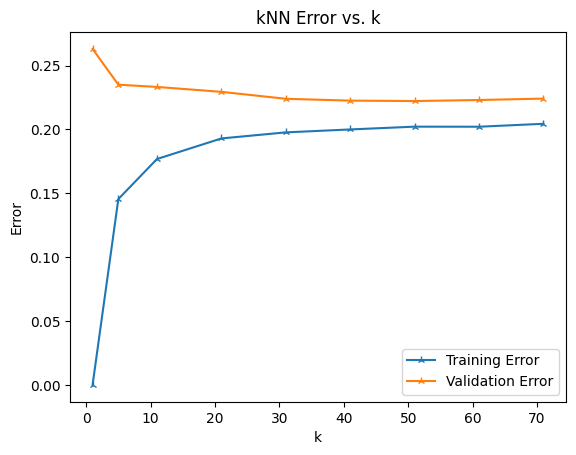

In [4]:
def plot_errors(k_vals, train_error, valid_error) -> None: 
    plt.plot(k_vals, train_error, label="Training Error", marker='2')
    plt.plot(k_vals, valid_error, label="Validation Error", marker='2')
    plt.xlabel("k")
    plt.ylabel("Error")
    plt.title("kNN Error vs. k")
    plt.legend(loc='lower right')

plot_errors(k_vals, train_error, valid_error)

In [5]:
# Get the k value with the lowest validation error
best_k_ind = sorted(enumerate(valid_error), key=lambda x: x[1])[0][0]
best_k = k_vals[best_k_ind]
print(f'Best k: {best_k}')

# Create a classifier and get its predictions + accuracy on the test set
clf = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
clf.fit(train_X, train_y)
test_acc = clf.score(test_X, test_y)
print(f'Test Accuracy of best kNN classifier: {(test_acc * 100):.2f}%')

Best k: 51
Test Accuracy of best kNN classifier: 73.40%


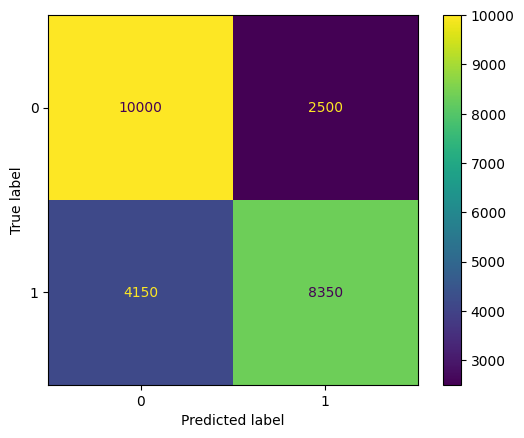

In [6]:
# Confusion matrix for kNN classifier with best_k
cf_display = ConfusionMatrixDisplay.from_estimator(clf, test_X, test_y, values_format='d')

Text(0.5, 1.0, 'Learning Curve for kNN Classifier')

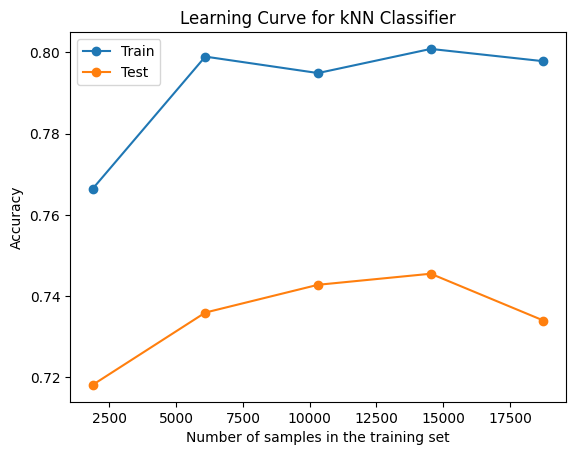

In [10]:
X_combined = sparse.vstack([train_X, test_X])
y_combined = np.concatenate([train_y, test_y])

test_fold = np.zeros(train_y.shape[0] + test_y.shape[0])
test_fold[:train_y.shape[0]] = -1

common_params = {
    "X": X_combined,
    "y": y_combined,
    "cv": PredefinedSplit(test_fold),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(clf, **common_params).ax_.set_title("Learning Curve for kNN Classifier")
